In [1]:
%pip install ultralytics
%pip install super-gradients
%pip install supervision
%pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.5/719.5 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 54.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.5/684.5 kB 22.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 58.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 81.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.6/408.6 kB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 64.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 56.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 24.4 MB

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 2.8 MB/s eta 0:00:00


In [2]:
from ultralytics import NAS

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [199]:
from super_gradients.training import models
import torch
DEVICE = 'cuda' if torch.cuda.is_available() else "cpu"

model_path = '/content/drive/MyDrive/5Modelos_Yolov8_DatasetTumor/YoloNas-S'

best_model = models.get(
    'yolo_nas_s',
    num_classes=1,
    checkpoint_path=f"{model_path}/average_model.pth"
).to(DEVICE)


[2024-03-09 21:33:44] INFO - checkpoint_utils.py - Successfully loaded model weights from /content/drive/MyDrive/5Modelos_Yolov8_DatasetTumor/YoloNas-S/average_model.pth checkpoint.


In [200]:
def calculate_iou(box1, box2):
    # Calcular a interseção
    x_intersection = max(0, min(box1[2], box2[2]) - max(box1[0], box2[0]))
    y_intersection = max(0, min(box1[3], box2[3]) - max(box1[1], box2[1]))
    area_intersection = x_intersection * y_intersection

    # Calcular a união
    area_box1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area_box2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    area_union = area_box1 + area_box2 - area_intersection

    # Calcular a IoU
    iou = area_intersection / max(area_union, 1e-10)  # Evitar divisão por zero

    return iou

In [201]:
import supervision as sv
import ultralytics
import numpy as np

def get_inference(path_project):
  ds = sv.DetectionDataset.from_yolo(
      images_directory_path=f"{path_project}/images",
      annotations_directory_path=f"{path_project}/labels",
      data_yaml_path=f"/content/drive/MyDrive/CsiLab-BrainTumor-Detection-3/data.yaml",
      force_masks=False
  )

  CONFIDENCE_TRESHOLD = 0.5
  predictions = {}
  for image_name, image in ds.images.items():
    result =best_model.predict(image, conf=CONFIDENCE_TRESHOLD)
    detections = sv.Detections(
        xyxy=result.prediction.bboxes_xyxy,
        confidence=result.prediction.confidence,
        class_id=result.prediction.labels.astype(int),
    )
    predictions[image_name] = detections

    nome_imagem = image_name.split('/')[7] + ".txt"
    np.savetxt(f"{model_path}/inferencias/{path_project.split('/')[5]}/{nome_imagem}",detections.xyxy, fmt= '%1.20f')

  for key in list(ds.images.keys()):
    # Para anotações
    annotation_detections = ds.annotations[key]
    for detection in annotation_detections:
      nome_imagem = (key.split('/')[7]).split('.jpg')[0] + ".txt"
      np.savetxt(f"{model_path}/anotacoes/{path_project.split('/')[5]}/{nome_imagem}",np.asarray(detection[0]).reshape(1,4), fmt= '%1.20f')



get_inference("/content/drive/MyDrive/CsiLab-BrainTumor-Detection-3/test")
get_inference("/content/drive/MyDrive/CsiLab-BrainTumor-Detection-3/train")
get_inference("/content/drive/MyDrive/CsiLab-BrainTumor-Detection-3/valid")

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
[2024-03-09 21:33:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-09 21:33:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-09 21:33:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-09 21:33:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-09 21:33:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-03-09 21

In [202]:
import os
import numpy as np
from statistics import mean
import pandas as pd

inference_paths = [f"{model_path}/inferencias/test",f"{model_path}/inferencias/train",f"{model_path}/inferencias/valid" ]
anotation_path = f"{model_path}/anotacoes"


iou_log = pd.DataFrame(columns=['Namelabel','LabelTrue','NamePredict','LabelPredict','iouResult'])

for inference_path in inference_paths:
  iou_result = []
  for filename in os.listdir(f"{inference_path}"):
    labels = (np.genfromtxt(os.path.join(f"{inference_path}", filename), dtype=float))  if np.shape(np.genfromtxt(os.path.join(f"{inference_path}", filename), dtype=float)) != (0,) else [0, 0, 0, 0]
    images = (os.path.join(f"{inference_path}", filename).split('/')[-1].split('.jpg')[0] +'.txt')
    label_v = (np.genfromtxt(os.path.join(f"{anotation_path}/{inference_path.split('/')[7]}", images), dtype=float))


    if np.shape(labels) == (4,):
      if np.shape(label_v) != (4,):
        iou_aux  = []
        for row in label_v:
          newRow = {'Namelabel': filename,
                    'LabelTrue':row,
                    'NamePredict': images,
                    'LabelPredict':labels,
                    'iouResult':calculate_iou(row,labels)}
          iou_log = iou_log.append(newRow, ignore_index=True)
          iou_aux.append(calculate_iou(row,labels))
        iou_result.append(max(iou_aux))
      else:
          newRow = {'Namelabel': filename,
                    'LabelTrue':label_v,
                    'NamePredict': images,
                    'LabelPredict':labels,
                    'iouResult':calculate_iou(label_v,labels)}
          iou_log = iou_log.append(newRow, ignore_index=True)
          iou_aux.append(calculate_iou(label_v,labels))
          iou_result.append(calculate_iou(label_v,labels))
    else:
      for label in labels:
        if np.shape(label_v) != (4,):
          iou_aux  = []
          for row in label_v:
            newRow = {'Namelabel': filename,
                      'LabelTrue':row,
                      'NamePredict': images,
                      'LabelPredict':label,
                      'iouResult':calculate_iou(row,label)}
            iou_log = iou_log.append(newRow, ignore_index=True)
            iou_aux.append(calculate_iou(row,label))
          iou_result.append(max(iou_aux))
        else:
            newRow = {'Namelabel': filename,
                      'LabelTrue':label_v,
                      'NamePredict': images,
                      'LabelPredict':label,
                      'iouResult':calculate_iou(label_v,label)}
            iou_log = iou_log.append(newRow, ignore_index=True)
            iou_aux.append(calculate_iou(label_v,label))
            iou_result.append(calculate_iou(label_v,label))


  with(open(f"{model_path}/iouMean_{inference_path.split('/')[7]}.txt",'w')) as file:
    file.write(str(mean(iou_result)))

  print(iou_log['iouResult'].mean())
  iou_log.to_csv(f"{model_path}/LogIoU_{inference_path.split('/')[7]}.csv", index=False)


<ipython-input-202-71463a623d31>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  iou_log = iou_log.append(newRow, ignore_index=True)
<ipython-input-202-71463a623d31>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  iou_log = iou_log.append(newRow, ignore_index=True)
<ipython-input-202-71463a623d31>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  iou_log = iou_log.append(newRow, ignore_index=True)
<ipython-input-202-71463a623d31>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  iou_log = iou_log.append(newRow, ignore_index=True)
<ipython-input-202-71463a623d31>:38: FutureWarning: The frame.append method is deprecated and will be re

0.8491785688621667


<ipython-input-202-71463a623d31>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  iou_log = iou_log.append(newRow, ignore_index=True)
<ipython-input-202-71463a623d31>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  iou_log = iou_log.append(newRow, ignore_index=True)
<ipython-input-202-71463a623d31>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  iou_log = iou_log.append(newRow, ignore_index=True)
<ipython-input-202-71463a623d31>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  iou_log = iou_log.append(newRow, ignore_index=True)
<ipython-input-202-71463a623d31>:38: FutureWarning: The frame.append method is deprecated and will be re

0.8679114564720416


<ipython-input-202-71463a623d31>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  iou_log = iou_log.append(newRow, ignore_index=True)
<ipython-input-202-71463a623d31>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  iou_log = iou_log.append(newRow, ignore_index=True)
<ipython-input-202-71463a623d31>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  iou_log = iou_log.append(newRow, ignore_index=True)
<ipython-input-202-71463a623d31>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  iou_log = iou_log.append(newRow, ignore_index=True)
<ipython-input-202-71463a623d31>:38: FutureWarning: The frame.append method is deprecated and will be re

In [140]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Função para gerar a matriz de confusão para um DataFrame
def generate_confusion_matrix(df):
    y_true = df['y_true'].values
    y_pred = df['y_pred'].values
    return confusion_matrix(y_true, y_pred)



'\n# Pasta contendo os arquivos Excel\nexcel_folder = "output_excel"\n\n# Lista de arquivos na pasta de Excel\nexcel_files = os.listdir(excel_folder)\n\n# Avaliar cada arquivo Excel\nfor excel_file in excel_files:\n    # Carregar o DataFrame do arquivo Excel\n    df = pd.read_excel(os.path.join(excel_folder, excel_file))\n\n    # Calcular a média do IoU\n    mean_iou = calculate_mean_iou(df)\n\n    # Contar quantos labels têm IoU maior que 0.5, 0.7 e 0.9\n    count_iou_05 = count_labels_iou(df, 0.5)\n    count_iou_07 = count_labels_iou(df, 0.7)\n    count_iou_09 = count_labels_iou(df, 0.9)\n\n    # Gerar a matriz de confusão\n    confusion_mat = generate_confusion_matrix(df)\n\n    # Salvar a matriz de confusão em um arquivo Excel\n    confusion_mat_df = pd.DataFrame(confusion_mat)\n    output_filename = excel_file.replace(\'.xlsx\', \'_confusion_matrix.xlsx\')\n    confusion_mat_df.to_excel(os.path.join(excel_folder, output_filename), index=False)\n\n    # Mostrar os resultados\n    p

<ipython-input-131-a4c7b62e2739>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred_list.append(int(prediction_list[i].class_id))


[[275  12]
 [  0   0]]


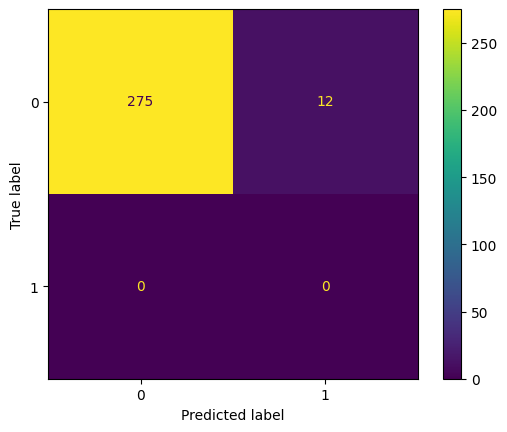

In [ ]:
data_true = np.loadtxt('/content/drive/MyDrive/5Modelos_Yolov8_DatasetTumor/Train6YoloNAS/detections.txt', dtype= str, delimiter = ',')
y_true_list = []
y_pred_list = []
for i in range(len(data_true)):
  y_true_list.append(int(data_true[i][7]))
  try:
    y_pred_list.append(int(prediction_list[i].class_id))
  except Exception as e:
    y_pred_list.append(1)

df = pd.DataFrame({"y_true":y_true_list,"y_pred":y_pred_list})
print(generate_confusion_matrix(df))
disp = ConfusionMatrixDisplay(generate_confusion_matrix(df))
disp.plot()
